# How to incorporate new regions?

This notebook aims at providing a preliminary overview about how to add new regions beyond the African continent.

## Guideline to extend the model to other regions

There are certain things we would recommend when you think about extending the model to another region. To help you progressing fast, we created this guideline.

- **Debug from the root of rules**

The snakemake workflow can be imagines as a tree. It has roots (rules without dependencies), that streamline over the tree trunk (rules that have dependencies) towards it's crown (rules with no following one). In our example the crown is the optimized network. As you cannot build a house starting with the roof of a house, you should make sure that you build it up from the bottom. So debug from bottom up, from rules without dependencies towards the rules which dependencies you already debugged and until you deserve the crown.

- **Use global data as default**

The first time you extend the model to another region, we recommend to relay on the global data and contribute code in harmony with PyPSA-Earth code. While global data might be sometimes less accurate, it has the great benefit that we stay one community that can build on each others developments. In this sense, **we try to build one code base** that works across the Earth so that your developments help everyone. 

- **Create linkers for country specific data**

The default data might be not always enough for your study purpose. We would encourage you to **create linkers** to replace the global default by the new more accurate data and contribute these linkers to the GitHub repository. For instance, you model North Africa, but have more accurate national weather data available for Egypt. While you use the global default data for all countries you could replace the Egyptian data with the linker. This linkers are not yet developed or tested (15.11.22) - but we have [ideas](https://github.com/pypsa-meets-earth/pypsa-earth/issues/499) on how to design them. Maybe it's an opportunity for a great contributions? 

- **Python first for fast developments. Understanding the bottlenecks**

Some people consider Python as slow. **Compiler speed is not really a bottleneck for us**. For instance, building the sector-coupled model in Europe from bottom up (executing all rules) takes about 10-15min, while solving a large optimization problem can take between 12-36 hours. What we really need is to develop as community fast, new and better features. Limiting the coding languages for all workflows to Python helps people with fast and easy to understand developments.

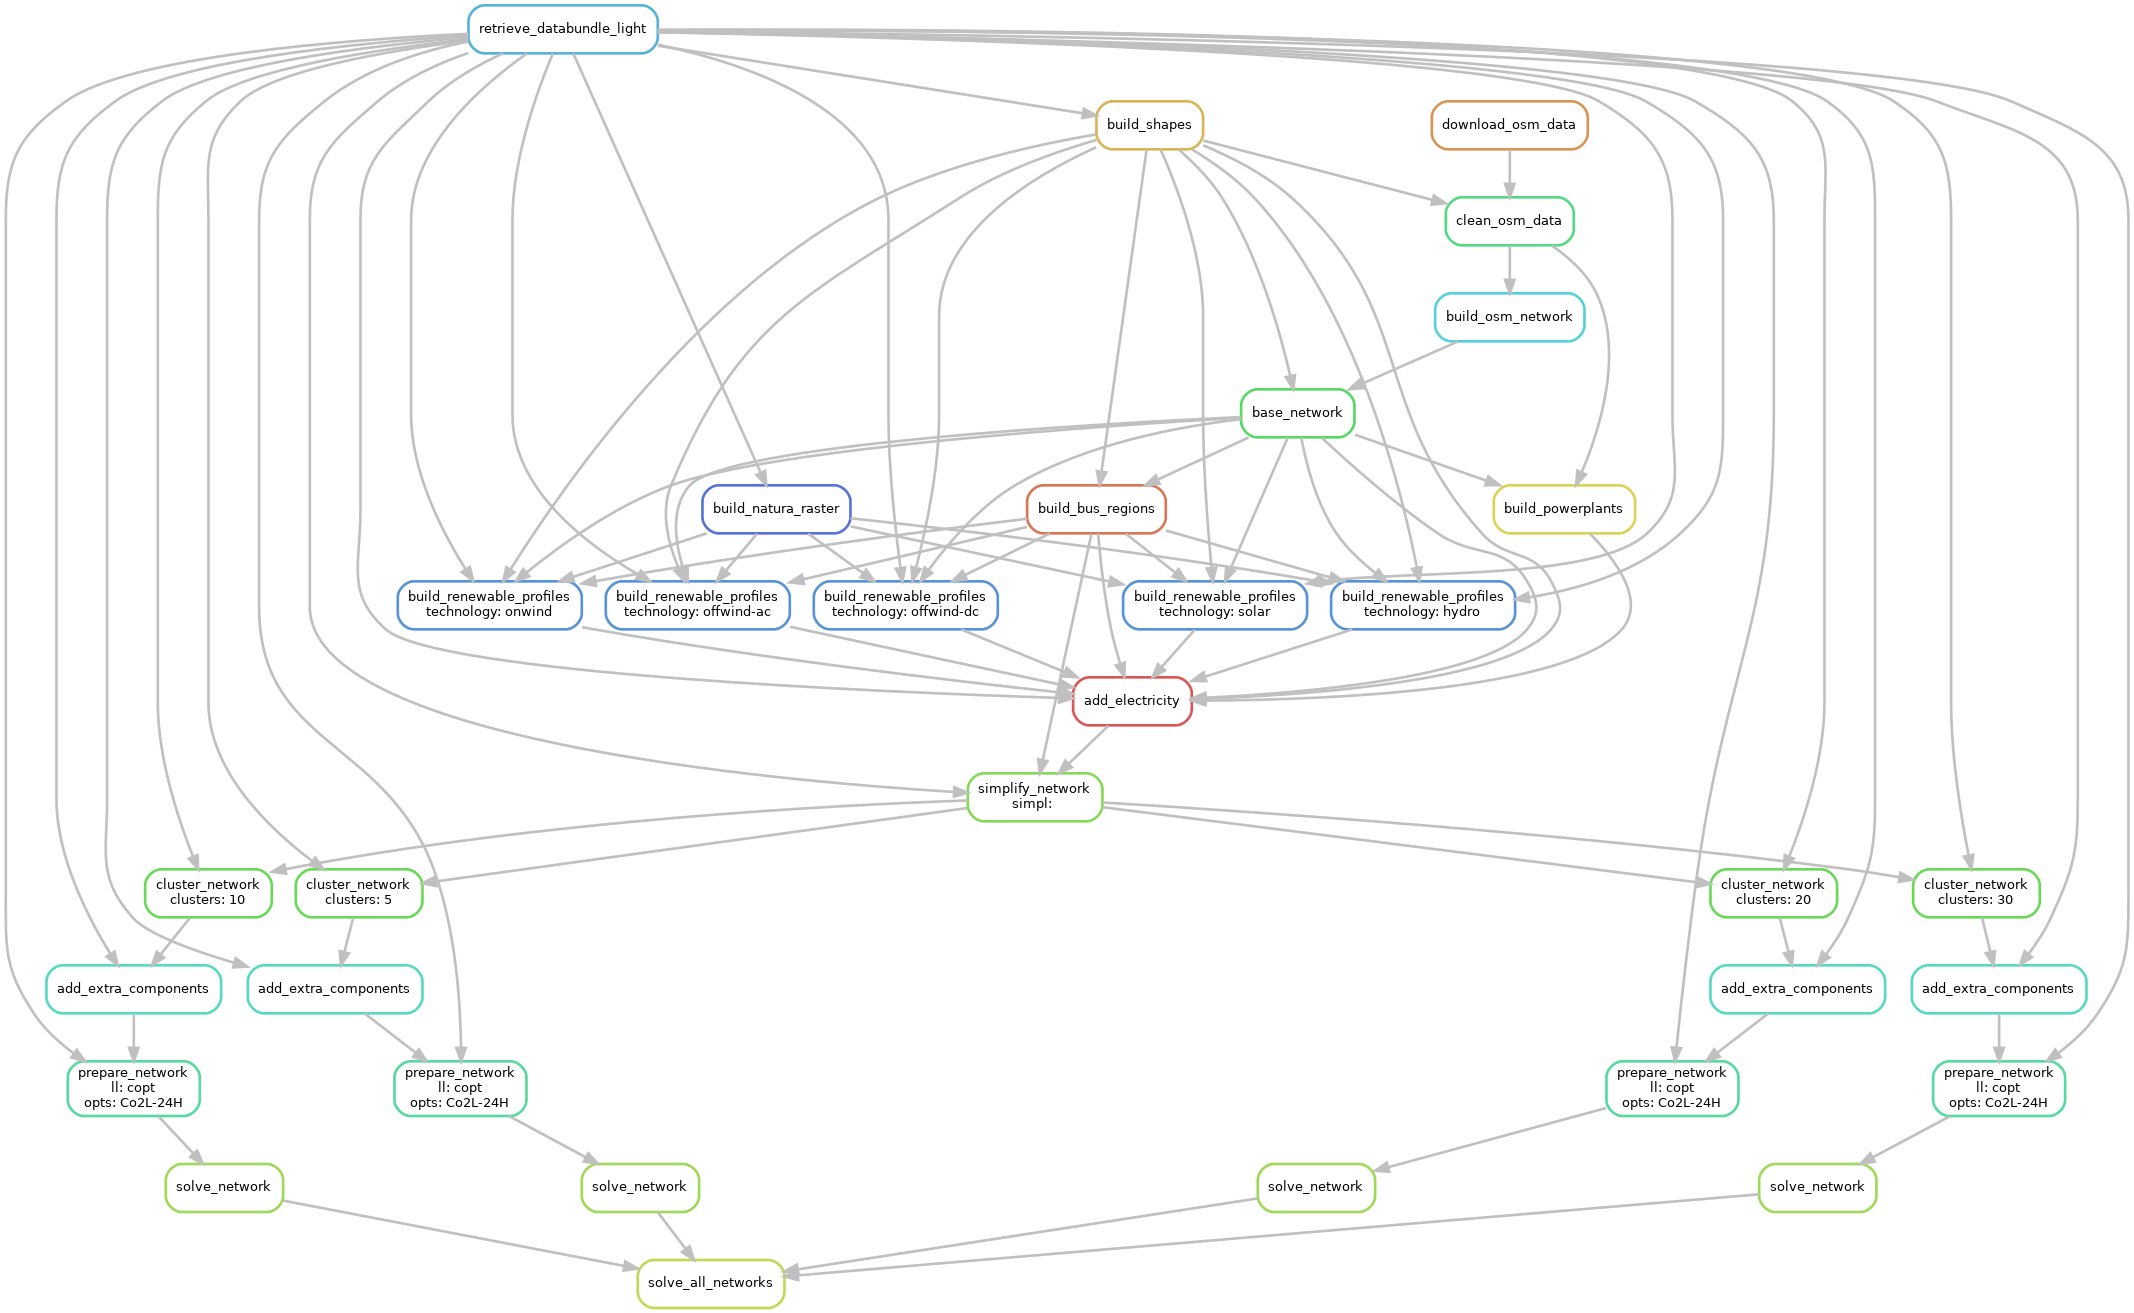

In [1]:
from IPython import display
display.Image("./images/hackathon/workflow_example.png")

## 1. The settings

### 1.1. Countries settings

First of all, to change the workflow to perform on a different region, the `config.yaml` file shall be modified to the desired countries.

For example, to perform the workflow on Turkey, the keyword shall be changed as follows:
``` python
    countries = ["TR"]
```

### 1.2. Cutout settings

The cutout is the main concept of climate data management in PyPSA ecosystem introduced in [atlite](https://atlite.readthedocs.io/en/latest/) package. The cutout is an archive containing a spatio-temporal subset of one or more topology and weather datasets.

It’s worth to check that there is a proper match between the requested countries list and the provided cutout throughout the configuration file. In case any mysterious error message appear during the first model run, there are chances that it can be resolved by a simple config check.

In particular, the cutout name should correspond to the appropriate nc file and be the same in the configuration file, e.g.:

```yaml
atlite:
  nprocesses: 4
  cutouts:
    # geographical bounds automatically determined from countries input
    africa-2013-era5:
```

```
renewable:
  onwind:
    cutout: africa-2013-era5
    resource:
      method: wind
...      
  offwind-ac:
    cutout: africa-2013-era5
    resource:
      method: wind
...
  offwind-dc:
    cutout: africa-2013-era5
    resource:
      method: wind
...      
  solar:
    cutout: africa-2013-era5
    resource:
      method: pv 
...      
  hydro:
    cutout: africa-2013-era5
    resource:
      method: hydro            
```


It could be helpful to keep in mind the following points:

1. the cutout name should be the same across the whole configuration file (there are several entries, one under under atlite and some under each of the renewable parameters);

2. the countries of interest defined with countries list in the config.yaml should be covered by the cutout area;

3. the cutout time dimension, the weather year used for demand modeling and the actual snapshot should match.

The pre-built cutout for Africa is available for 2013 year and can be loaded directly from zenodo through the rule `retrieve_cutout`. There is also a smaller cutout for Africa built for a two-weeks time span; it is automatically downloaded when retrieving common data with `retrieve_databundle_light`. In case you are interested in other parts of the world you have to generate a cutout yourself using the `build_cutouts` rule.

## 2. Input files

### 2.1. Introduction

The current input files have been tested on the African countries, thus, for other regions appropriate input data may be missing and may be added or replaced.

In particular, in the current workflow some input files needed are automatically downloaded from the original sources by countries according to the list of countries provided by the keyword `countries` in the file `config.yaml`. Some examples are: OpenStreetMap (osm) data, downloaded by the rule `download_osm_data` or the GADM shapes, by the rule `build_shapes`. These data are located in the `recources` folder. 

Other data sometimes cannot be automatically downloaded from the original source along the workflow.  Instead we prepared a databundle (zip files) that is automatically downloaded from google drive to the `data` folder. The input data contained in these files are mainly of the global scope and normally need your attention only if you want understand the underlaying assumptions better.

The input data are contained in the folders `data` and `resources`. We provide below some comments about what are the files that can be investigated.

Below, we add comments about each folder and the files that shall be addressed:

### 2.2. Folder `data`

- `data/landcover`: regional-specific data are being downloaded to reduce the needed space; these files shall be changed according to the areas of interest. Data downloaded from the following [link](https://www.protectedplanet.net/en/thematic-areas/wdpa?tab=WDPA). However, these landcover data are needed only to generate the custom natura.tiff raster file which is provided by default with the global resolution.

**No changes expected**
- `data/hydrobasins`: global data on watershed boundaries and basins
- `data/copernicus`: data with global extension
- `data/eez`: global marittime data already loaded
- `data/gadm`: data downloaded with global scope from build_shapes rule
- `data/GDP`: data already with global scope
- `data/gebco`: data already with global scope
- `data/worldpop`: data automatically downloaded from build_shapes rule

### 2.3. Folder `resources`

The resources folder contains main inputs for the resource and load estimation.

No changes are expected; all the files are generated automatically by the workflow.

### 2.4. Folder `resources/cutouts`

The folder `cutouts` accommodates the cutouts files that contains timeseries of the renewable production for the region of interest, which are generated using [Atlite](https://github.com/PyPSA/atlite).
Currently, after you download the data from the google drive, you can find a pre-compiled file already built for Africa, for simplicity; however, if a different region shall be investigated, then the file has to be generated for the specific region.

To do so, it is possible enable the rule `build_cutout`, which automatically generates the cutout for the selected regions by using Atlite. Enabling it and downloading the data can take 1-2 days for a continent depending on the status of the server. To enable the rule, you shall go into the `config.yaml` file and change the corresponding boolean value in the `enable` section

``` python
enable:
  build_cutout: true
```

Normally cutout extent is calculated from the shape of the requested region defined by the `countries` parameter in the configuration file `config.yaml`. It could make sense to set the countries list as big as it's feasible when generating a cutout. A considered area can be narrowed anytime when building a specific model by adjusting content of the `countries` list.

To run `build_cutout` rule you will need to: 

1. be registered on  the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu);

2. install `cdsapi` package  (can be installed with `pip`);

3. setup your CDS API key as described [on their website](https://cds.climate.copernicus.eu/api-how-to).

These steps are required to use CDS API which allows an automatic file download while executing `build_cutouts` rule.

**Once the build_cutout has been executed, we recommend to disable it, once the files have been generated.** Be aware that the cutouts file are very large 10-20GB for 1 continent.